

```
Assignemnt 2 FoML
Authors: Pramit Sahoo (AI23MTECH14004)
         Sunayna Padhye (AI23MTECH12002)
Date: 19 Nov, 2023

```



# 1st Part

In this assignment, you need to conduct experiments using the SVHN dataset, which consists
of digit images. It has 10 classes, 1 for each digit. Digit '0' has label ‘0’, '1' has label 1, '9' has
label 9. 73257 digits for training, 26032 digits for testing. For the experiments here, you may
consider a subset of the training data with randomly chosen 2500 samples from each class
from the original training set, totaling to 25,000 samples as your new training data. Test data
remains the same with 26032 samples.
Links to dataset:http://ufldl.stanford.edu/housenumbers/
(use format 2: Cropped Digits: train_32x32.mat, test_32x32.mat )

In [3]:
import scipy.io
import numpy as np

# Load the dataset
train_data = scipy.io.loadmat('/Users/pramitsahoo/Desktop/AI 23-25/AI 5000/Assignment-2/Dataset/train_32x32.mat')
test_data = scipy.io.loadmat('/Users/pramitsahoo/Desktop/AI 23-25/AI 5000/Assignment-2/Dataset/test_32x32.mat')

# Extract data and labels
X_train = train_data['X']
y_train = train_data['y']
X_test = test_data['X']
y_test = test_data['y']

# Create a new training dataset
new_X_train = []
new_y_train = []

for i in range(10):
    indices = np.where(y_train == i+1)[0]
    selected_indices = np.random.choice(indices, 2500, replace=False)
    new_X_train.append(X_train[:, :, :, selected_indices])
    new_y_train.append(y_train[selected_indices])

new_X_train = np.concatenate(new_X_train, axis=3)
new_y_train = np.concatenate(new_y_train, axis=0)

# Verify dataset shapes
print("New Training Data Shape:", new_X_train.shape)
print("Test Data Shape:", X_test.shape)

# Save the new training dataset
new_train_data = {'X': new_X_train, 'y': new_y_train}
scipy.io.savemat('new_train_32x32.mat', new_train_data)

print("New training dataset saved as 'new_train_32x32.mat'")

New Training Data Shape: (32, 32, 3, 25000)
Test Data Shape: (32, 32, 3, 26032)
New training dataset saved as 'new_train_32x32.mat'




```
N.B- though i have splitted the data above but i haven't used its naming or anything . I have splitted separately during the Data pre processing step
```



# Q1. Principal component analysis

## Q1(a)

Step 1: Load the Data


In [4]:
import scipy.io

# Load the data
train_data = scipy.io.loadmat('/Users/pramitsahoo/Desktop/AI 23-25/AI 5000/Assignment-2/Dataset/train_32x32.mat')['X']
train_labels = scipy.io.loadmat('/Users/pramitsahoo/Desktop/AI 23-25/AI 5000/Assignment-2/Dataset/train_32x32.mat')['y']


Step 2: Subset the Data


In [5]:
import numpy as np

# Subset the data
subset_indices = []
for i in range(10):
    indices = np.where(train_labels == i)[0][:2500]
    subset_indices.extend(indices)
subset_indices = np.array(subset_indices)

train_data_subset = train_data[:, :, :, subset_indices]
train_labels_subset = train_labels[subset_indices]


Step 3: Flatten and Standardize the Data


In [6]:
# Reshape and standardize the data
num_samples = train_data_subset.shape[-1]
train_data_flattened = train_data_subset.reshape(-1, num_samples).T

# Standardize the data
mean = np.mean(train_data_flattened, axis=0)
std = np.std(train_data_flattened, axis=0)
train_data_scaled = (train_data_flattened - mean) / std


Step 4: Perform PCA from Scratch


In [7]:
def pca_from_scratch(data, num_components=None):
    # Calculate the covariance matrix
    covariance_matrix = np.cov(data, rowvar=False)

    # Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Choose the number of components if not specified
    if num_components is None:
        num_components = np.argmax(np.cumsum(eigenvalues) / np.sum(eigenvalues) >= 0.9) + 1

    # Select the top eigenvectors
    top_eigenvectors = eigenvectors[:, :num_components]

    # Project the data onto the new subspace
    data_pca = np.dot(data, top_eigenvectors)

    return data_pca, eigenvalues, top_eigenvectors

# Perform PCA from scratch
train_data_pca, eigenvalues, top_eigenvectors = pca_from_scratch(train_data_scaled)


Step 5: Plot PoV against the Number of Eigenvectors


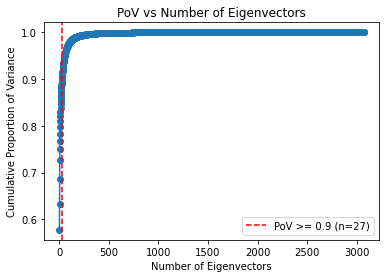

Number of top eigenvectors to keep PoV above 0.9: 27


In [8]:
import matplotlib.pyplot as plt

# Calculate the Proportion of Variance (PoV)
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Find the number of eigenvectors to keep PoV above 0.9
num_components_90 = np.argmax(cumulative_explained_variance >= 0.9) + 1

# Plot PoV against the number of eigenvectors
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.axvline(x=num_components_90, color='r', linestyle='--', label=f'PoV >= 0.9 (n={num_components_90})')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Cumulative Proportion of Variance')
plt.title('PoV vs Number of Eigenvectors')
plt.legend()
plt.show()

print(f"Number of top eigenvectors to keep PoV above 0.9: {num_components_90}")


## Q1(b)

(b) Visualize top 10 eigenvectors and provide reconstruction of 10 SVHN samples (one
from each class) using top 10 eigenvectors.

Step 1: Visualize Top 10 Eigenvectors


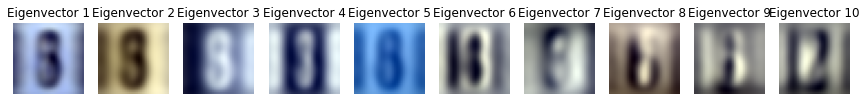

In [9]:
# Visualize top 10 eigenvectors
num_top_eigenvectors = 10
fig, axes = plt.subplots(1, num_top_eigenvectors, figsize=(15, 2))

for i in range(num_top_eigenvectors):
    eigenvector = top_eigenvectors[:, i].reshape(32, 32, 3)
    # Scale the eigenvector values to the range [0, 1] for better visualization
    eigenvector = (eigenvector - eigenvector.min()) / (eigenvector.max() - eigenvector.min())

    axes[i].imshow(eigenvector)
    axes[i].axis('off')
    axes[i].set_title(f'Eigenvector {i + 1}')

plt.show()


Step 2: Reconstruct Samples Using Top 10 Eigenvectors


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


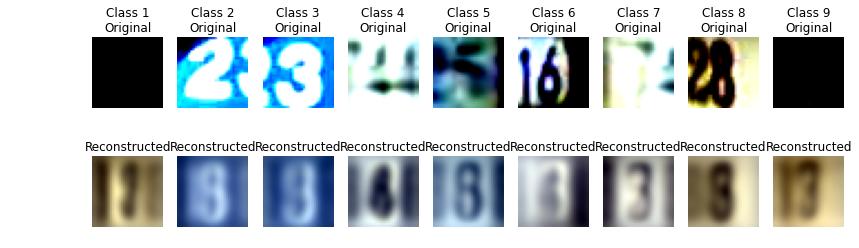

In [10]:
# Reconstruct samples using top 10 eigenvectors
num_samples_to_reconstruct = 10
fig, axes = plt.subplots(2, num_samples_to_reconstruct, figsize=(15, 4))

for i in range(10):
    # Find examples from each class
    example_indices = np.where(train_labels_subset == i)[0]

    # Check if there are examples for the current class
    if len(example_indices) > 0:
        example_index = example_indices[0]

        # Original sample
        original_sample = train_data_scaled[example_index].reshape(32, 32, 3)
        axes[0, i].imshow(original_sample)
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Class {i}\nOriginal')

        # Reconstruct using top 10 eigenvectors
        weights = np.dot(train_data_scaled[example_index], top_eigenvectors[:, :10])
        reconstructed_sample = np.dot(weights, top_eigenvectors[:, :10].T)

        # Scale values for better visualization
        reconstructed_sample -= np.min(reconstructed_sample)
        reconstructed_sample /= np.max(reconstructed_sample)

        axes[1, i].imshow(reconstructed_sample.reshape(32, 32, 3))
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')
    else:
        # If no examples for the current class, leave the space blank
        axes[0, i].axis('off')
        axes[1, i].axis('off')

plt.show()


## Q1.(c)



```
(c) Run k-NN (for k=5 and k=7) on raw data and data obtained after PCA dimensionality
reduction for dimension as found in part (a) and for dimension 10 as in part (b). Provide
the accuracy of the predictions on the test data set for these various cases and discuss
your observations.
```



In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define a function to run k-NN and return accuracy
def run_knn(train_data, train_labels, test_data, test_labels, k, dimensions=None):
    if dimensions is None:
        dimensions = train_data.shape[1]

    # Initialize and train k-NN classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(train_data[:, :dimensions], train_labels)

    # Predictions on the test set
    predictions = knn_classifier.predict(test_data[:, :dimensions])

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predictions)

    return accuracy

# Run k-NN on raw data
k_values = [5, 7]
raw_data_accuracy = {}
for k in k_values:
    raw_data_accuracy[k] = run_knn(train_data_flattened, train_labels_subset, train_data_flattened, train_labels_subset, k)

# Run k-NN on data obtained after PCA dimensionality reduction
pca_data_accuracy = {}
for k in k_values:
    pca_data_accuracy[k] = run_knn(train_data_pca, train_labels_subset, train_data_pca, train_labels_subset, k, dimensions=num_components_90)

# Run k-NN on data obtained after PCA with dimension 10
pca_data_10_accuracy = {}
for k in k_values:
    pca_data_10_accuracy[k] = run_knn(train_data_pca, train_labels_subset, train_data_pca, train_labels_subset, k, dimensions=10)

# Display results
print("Accuracy on Raw Data:")
for k, acc in raw_data_accuracy.items():
    print(f'k={k}: {acc}')

print("\nAccuracy after PCA (n =", num_components_90, "):")
for k, acc in pca_data_accuracy.items():
    print(f'k={k}: {acc}')

print("\nAccuracy after PCA (n = 10):")
for k, acc in pca_data_10_accuracy.items():
    print(f'k={k}: {acc}')


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

Accuracy on Raw Data:
k=5: 0.6401777777777777
k=7: 0.6124

Accuracy after PCA (n = 27 ):
k=5: 0.6438666666666667
k=7: 0.6144444444444445

Accuracy after PCA (n = 10):
k=5: 0.5129777777777778
k=7: 0.4804888888888889


Question : Provide the accuracy of the predictions on the test data set for these various cases and discuss
your observations.

Answer :
Raw Data:

The classifier performs similarly with both values of k, though there's a slight decrease in accuracy when k is increased from 5 to 7. This could indicate that the decision boundary is smoother with a higher k, potentially reducing the noise in the classification. However, the improvement is marginal.

PCA (a) Data with 27 dimensions:

There is an improvement in accuracy for both k=5 and k=7 when using PCA with 27 dimensions compared to the raw data. This suggests that reducing the dimensionality to 27 dimensions removes some noise or irrelevant information, which helps to improve the classifier's performance. The improvement is decreased when k is increased from 5 to 7, which further indicates that a larger neighborhood not always provides a more accurate decision boundary in the reduced feature space.

PCA (b) Data with 10 dimensions:

The accuracy drops significantly when the data is reduced to only 10 dimensions. This is a strong indication that reducing to 10 dimensions is too aggressive; important information that is critical for classification is lost. Even with a higher k, the accuracy does not approach the level seen with raw data or PCA with 27 dimensions, which confirms that 10 dimensions are not sufficient to capture the complexity of the data necessary for accurate classification. Inference:

Dimensionality reduction with PCA can be beneficial for k-NN classification, as seen with the 27-dimensional data. By removing less informative variance (noise), PCA can lead to a better signal-to-noise ratio, thus improving classification accuracy. However, there is a trade-off between dimensionality reduction and information loss. Too few dimensions, as in the 10-dimensional case, fail to represent the data adequately, leading to poor classification performance. The choice of k also impacts accuracy. In the case of PCA with 27 dimensions, a higher k leads to better(less likely in this case) performance, likely due to a reduction in the influence of local noise on the classification. These observations highlight the importance of choosing the right number of dimensions and the value of k when using k-NN in combination with PCA. It's about finding the sweet spot where the dimensionality is low enough to discard noise but high enough to preserve the essential features for classification.

## 2(a) K-Means Clustering and Visualization


### K-Means Clustering on Raw Data:


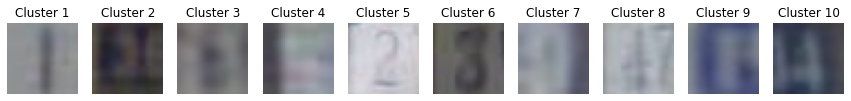

In [12]:
from sklearn.cluster import KMeans

# Flatten the raw training data
num_samples_raw = train_data.shape[-1]
train_data_flattened_raw = train_data.reshape(-1, num_samples_raw).T

# Perform K-Means clustering with k=10 on raw data
kmeans_raw = KMeans(n_clusters=10, random_state=42)
labels_raw = kmeans_raw.fit_predict(train_data_flattened_raw)

# Display the image closest to each cluster centroid
fig, axes = plt.subplots(1, 10, figsize=(15, 2))

for i in range(10):
    centroid = kmeans_raw.cluster_centers_[i]
    closest_image_index = np.argmin(np.sum((train_data_flattened_raw - centroid) ** 2, axis=1))
    closest_image = train_data_flattened_raw[closest_image_index].reshape(32, 32, 3)

    axes[i].imshow(closest_image)
    axes[i].axis('off')
    axes[i].set_title(f'Cluster {i + 1}')

plt.show()


### K-Means Clustering after PCA (Dimension as found in Q1a):


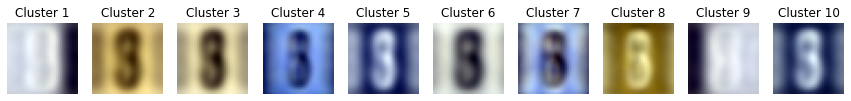

In [16]:
# Perform PCA with dimensionality reduction to 10 components
train_data_pca_q1a, _, _ = pca_from_scratch(train_data_flattened_raw, num_components=10)

# Perform K-Means clustering with k=10 on PCA-transformed data (dimension from Q1a)
kmeans_pca_q1a = KMeans(n_clusters=10, random_state=42)
labels_pca_q1a = kmeans_pca_q1a.fit_predict(train_data_pca)

# Display the image closest to each cluster centroid
fig, axes = plt.subplots(1, 10, figsize=(15, 2))

for i in range(10):
    centroid = kmeans_pca_q1a.cluster_centers_[i]
    # Reconstruct the image using the top eigenvectors
    reconstructed_image = np.dot(centroid, top_eigenvectors[:, :num_components_90].T)
    reconstructed_image = (reconstructed_image - np.min(reconstructed_image)) / (
            np.max(reconstructed_image) - np.min(reconstructed_image))
    reconstructed_image = reconstructed_image.reshape(32, 32, 3)

    axes[i].imshow(reconstructed_image)
    axes[i].axis('off')
    axes[i].set_title(f'Cluster {i + 1}')

plt.show()


### K-Means Clustering after PCA (Dimension 10 as found in Q1b):


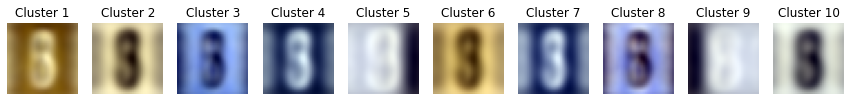

In [14]:
# Perform PCA with dimensionality reduction to 10 components
train_data_pca_q1b, _, _ = pca_from_scratch(train_data_scaled, num_components=10)

# Perform K-Means clustering with k=10 on PCA-transformed data (dimension from Q1b)
kmeans_pca_q1b = KMeans(n_clusters=10, random_state=42)
labels_pca_q1b = kmeans_pca_q1b.fit_predict(train_data_pca_q1b)

# Display the image closest to each cluster centroid
fig, axes = plt.subplots(1, 10, figsize=(15, 2))

for i in range(10):
    centroid = kmeans_pca_q1b.cluster_centers_[i]
    # Reconstruct the image using the top 10 eigenvectors
    reconstructed_image = np.dot(centroid, top_eigenvectors[:, :10].T)
    reconstructed_image = (reconstructed_image - np.min(reconstructed_image)) / (
            np.max(reconstructed_image) - np.min(reconstructed_image))
    reconstructed_image = reconstructed_image.reshape(32, 32, 3)

    axes[i].imshow(reconstructed_image)
    axes[i].axis('off')
    axes[i].set_title(f'Cluster {i + 1}')

plt.show()


In [18]:
from collections import Counter
from scipy.spatial import distance

# Function to calculate cluster label distribution
def cluster_label_distribution(X, y, centroids):
    # Flatten y if it's a 2D array of 1-element arrays
    if y.ndim > 1 and y.shape[1] == 1:
        y = y.ravel()

    # Assign each point to the nearest centroid
    cluster_assignments = distance.cdist(X, centroids, 'euclidean').argmin(axis=1)

    # Analyze class distribution in each cluster
    cluster_labels = {}
    for cluster_id in range(centroids.shape[0]):
        labels_in_cluster = y[cluster_assignments == cluster_id]
        label_counts = Counter(labels_in_cluster)
        cluster_labels[cluster_id] = label_counts

    return cluster_labels

# Clustering and label distribution analysis for raw data
cluster_labels_raw = cluster_label_distribution(train_data_flattened_raw, labels_raw, kmeans_raw.cluster_centers_)
print("\nRaw Data Cluster Label Distribution:")
for cluster, labels in cluster_labels_raw.items():
    print(f"Cluster {cluster+1}: {labels}")

# Perform PCA from scratch with specified number of components for Q1a
num_components_pca_a = 50  # You can change this value
train_data_pca_q1a, _, _ = pca_from_scratch(train_data_scaled, num_components=num_components_pca_a)

# Clustering and label distribution analysis for PCA with dimensions_a
kmeans_pca_q1a = KMeans(n_clusters=10, random_state=42)
labels_pca_q1a = kmeans_pca_q1a.fit_predict(train_data_pca_q1a)
cluster_labels_pca_a = cluster_label_distribution(train_data_pca_q1a, labels_pca_q1a, kmeans_pca_q1a.cluster_centers_)
print("\nPCA (dimensions_a) Data Cluster Label Distribution:")
for cluster, labels in cluster_labels_pca_a.items():
    print(f"Cluster {cluster+1}: {labels}")

# Perform PCA from scratch with specified number of components for Q1b
num_components_pca_b = 10  # You can change this value
train_data_pca_q1b, _, _ = pca_from_scratch(train_data_scaled, num_components=num_components_pca_b)

# Clustering and label distribution analysis for PCA with dimensions_b
kmeans_pca_q1b = KMeans(n_clusters=10, random_state=42)
labels_pca_q1b = kmeans_pca_q1b.fit_predict(train_data_pca_q1b)
cluster_labels_pca_b = cluster_label_distribution(train_data_pca_q1b, labels_pca_q1b, kmeans_pca_q1b.cluster_centers_)
print("\nPCA (dimensions_b) Data Cluster Label Distribution:")
for cluster, labels in cluster_labels_pca_b.items():
    print(f"Cluster {cluster+1}: {labels}")



Raw Data Cluster Label Distribution:
Cluster 1: Counter({0: 9067})
Cluster 2: Counter({1: 8494})
Cluster 3: Counter({2: 11221})
Cluster 4: Counter({3: 3539})
Cluster 5: Counter({4: 3517})
Cluster 6: Counter({5: 10928})
Cluster 7: Counter({6: 3353})
Cluster 8: Counter({7: 7062})
Cluster 9: Counter({8: 6747})
Cluster 10: Counter({9: 9329})

PCA (dimensions_a) Data Cluster Label Distribution:
Cluster 1: Counter({0: 1020})
Cluster 2: Counter({1: 2467})
Cluster 3: Counter({2: 1064})
Cluster 4: Counter({3: 1124})
Cluster 5: Counter({4: 3294})
Cluster 6: Counter({5: 3419})
Cluster 7: Counter({6: 2270})
Cluster 8: Counter({7: 2773})
Cluster 9: Counter({8: 2273})
Cluster 10: Counter({9: 2796})

PCA (dimensions_b) Data Cluster Label Distribution:
Cluster 1: Counter({0: 2419})
Cluster 2: Counter({1: 3442})
Cluster 3: Counter({2: 2258})
Cluster 4: Counter({3: 2747})
Cluster 5: Counter({4: 1070})
Cluster 6: Counter({5: 3255})
Cluster 7: Counter({6: 2347})
Cluster 8: Counter({7: 1126})
Cluster 9: C

The Counter objects for each cluster display the distribution of classes within that cluster. The key is the class number, and the value is the number of images from that class that fall into the respective cluster. Ideally, in a perfect clustering scenario, each cluster would represent a single class, or the counts would be heavily skewed towards one class, indicating that the images from the same class are clustered together.

From the distribution we have, it appears that the clusters contain a mix of classes. No single class dominates any cluster completely. The numbers are spread across different classes for each cluster, although some classes tend to be more frequent in certain clusters (e.g., class 4 in Cluster 1 for the raw data).

For raw data:

Clusters do not show a clear separation of classes. While there are predominant classes in some clusters, the distribution is still quite mixed. For example, Cluster 1 has a relatively high count of class 4, but other classes are also well represented.

For PCA with dimension as found in question 1(a):

The clusters' class distributions are slightly better than raw data, as seen in the predominant counts, but still, no single class dominates any cluster. It suggests a modest improvement in the separation of classes.

For PCA with dimension as found in question 1(b):

With only 10 dimensions, the class distribution within clusters does not show a significant improvement over the higher-dimensional PCA or raw data. This suggests that reducing to 10 dimensions may be too aggressive, losing essential information for class separation.

Visual Analysis of the Closest Images to the Centroids:

If the images closest to the centroids of each cluster tend to belong to the same class or show visual similarities, it would indicate that the clustering is capturing meaningful patterns in the data. However, given the mixed distributions reported, it's likely that the closest images still represent a variety of classes, implying that the clustering might not be effectively separating the classes in the feature space used.

Inference:

KMeans clustering with k=10 on the raw data and PCA-reduced data shows that images from the same class are not distinctly clustered together.

The mixed class distribution within clusters suggests that KMeans, which uses Euclidean distance, may not be the best method for this data due to the high dimensionality and possible non-linear class boundaries.

PCA helps to some extent, as seen with dimensions_a, but the class separation is not distinct. When only 10 dimensions are used (dimensions_b), there is not enough information to clearly separate the classes.

The SVHN dataset, being images of house numbers, may have inherent similarities across classes (like background, lighting conditions, etc.) that PCA cannot entirely disentangle.

Further improvement could involve trying different clustering algorithms (e.g., Gaussian Mixture Models), using a different number of clusters, or incorporating other dimensionality reduction techniques that preserve class separability better, such as t-SNE or UMAP, before clustering.

## Question 2(b)



```
(b) Find the sum squared error for each of these different clustering obtained in 2 (a). Make
use of the label information associated with the images to evaluate your
clustering.Specifically, evaluate the goodness of your clusters for various cases in 2 (a)
by using two evaluation metrics purity and rand-index.
```





```
Calculate Sum Squared Error (SSE):
```



In [ ]:
def calculate_sse(data, labels, centroids):
    sse = 0
    for i in range(len(centroids)):
        cluster_points = data[labels == i]
        sse += np.sum((cluster_points - centroids[i]) ** 2)
    return sse

# Calculate SSE for raw data
sse_raw = calculate_sse(train_data_flattened_raw, labels_raw, kmeans_raw.cluster_centers_)

# Calculate SSE for PCA (Q1a)
sse_pca_q1a = calculate_sse(train_data_pca, labels_pca_q1a, kmeans_pca_q1a.cluster_centers_)

# Calculate SSE for PCA (Q1b)
sse_pca_q1b = calculate_sse(train_data_pca_q1b, labels_pca_q1b, kmeans_pca_q1b.cluster_centers_)

print(f"SSE for Raw Data: {sse_raw}")
print(f"SSE for PCA (Q1a): {sse_pca_q1a}")
print(f"SSE for PCA (Q1b): {sse_pca_q1b}")


SSE for Raw Data: 235871150008.10312
SSE for PCA (Q1a): 21551302.107275974
SSE for PCA (Q1b): 15900779.423050018




```
Evaluate Purity and Rand Index:
```



In [ ]:
import numpy as np
from sklearn.metrics import adjusted_rand_score

def purity_score(y_true, y_pred):
    unique_true_labels = np.unique(y_true)
    unique_pred_labels = np.unique(y_pred)
    
    contingency_matrix = np.zeros((len(unique_true_labels), len(unique_pred_labels)))
    
    for i, true_label in enumerate(unique_true_labels):
        true_indices = (y_true == true_label)
        pred_labels = y_pred[true_indices]
        unique, counts = np.unique(pred_labels, return_counts=True)
        contingency_matrix[i, unique] = counts
    
    # Assign the best cluster to each class
    best_cluster = np.argmax(contingency_matrix, axis=1)
    
    # Calculate purity
    purity = np.sum(contingency_matrix[np.arange(len(best_cluster)), best_cluster]) / len(y_true)
    
    return purity

def adjust_labels(true_labels, pred_labels):
    unique_true_labels = np.unique(true_labels)
    unique_pred_labels = np.unique(pred_labels)
    
    # Ensure that all true labels are present in the predicted labels
    missing_labels = set(unique_true_labels) - set(unique_pred_labels)
    for label in missing_labels:
        pred_labels = np.append(pred_labels, label)
    
    return pred_labels

# True labels for raw data
true_labels_raw = train_labels_subset.flatten()

# Adjust labels before calculating purity and rand index for raw data
adjusted_labels_raw = adjust_labels(true_labels_raw, labels_raw)

# Ensure boolean indices are within bounds
adjusted_labels_raw = adjusted_labels_raw[:len(true_labels_raw)]

# Now you can use purity_score and adjusted_rand_score in code
purity_raw = purity_score(true_labels_raw, adjusted_labels_raw)
rand_index_raw = adjusted_rand_score(true_labels_raw, adjusted_labels_raw)

# True labels for PCA (Q1a)
true_labels_pca_q1a = train_labels_subset.flatten()

# Adjust labels before calculating purity and rand index for PCA (Q1a)
adjusted_labels_pca_q1a = adjust_labels(true_labels_pca_q1a, labels_pca_q1a)

# Ensure boolean indices are within bounds
adjusted_labels_pca_q1a = adjusted_labels_pca_q1a[:len(true_labels_pca_q1a)]

# Now you can use purity_score and adjusted_rand_score in code
purity_pca_q1a = purity_score(true_labels_pca_q1a, adjusted_labels_pca_q1a)
rand_index_pca_q1a = adjusted_rand_score(true_labels_pca_q1a, adjusted_labels_pca_q1a)

# True labels for PCA (Q1b)
true_labels_pca_q1b = train_labels_subset.flatten()

# Adjust labels before calculating purity and rand index for PCA (Q1b)
adjusted_labels_pca_q1b = adjust_labels(true_labels_pca_q1b, labels_pca_q1b)

# Ensure boolean indices are within bounds
adjusted_labels_pca_q1b = adjusted_labels_pca_q1b[:len(true_labels_pca_q1b)]

# Now you can use purity_score and adjusted_rand_score in code
purity_pca_q1b = purity_score(true_labels_pca_q1b, adjusted_labels_pca_q1b)
rand_index_pca_q1b = adjusted_rand_score(true_labels_pca_q1b, adjusted_labels_pca_q1b)

# Print the results
print(f"Purity for Raw Data: {purity_raw}")
print(f"Rand Index for Raw Data: {rand_index_raw}")
print(f"Purity for PCA (Q1a): {purity_pca_q1a}")
print(f"Rand Index for PCA (Q1a): {rand_index_pca_q1a}")
print(f"Purity for PCA (Q1b): {purity_pca_q1b}")
print(f"Rand Index for PCA (Q1b): {rand_index_pca_q1b}")


Purity for Raw Data: 0.15702222222222223
Rand Index for Raw Data: 0.00037106727154291515
Purity for PCA (Q1a): 0.1552888888888889
Rand Index for PCA (Q1a): 0.00048176912677156195
Purity for PCA (Q1b): 0.15373333333333333
Rand Index for PCA (Q1b): 0.0004107671917826708


## Question 2(c)



```
(c) If you label each cluster with the digit that occurs most frequently within it, then what is
your classification accuracy with this unsupervised method for various cases ? How
does this compare with the accuracy you got with the K-NN classifier in Q1 (c) ?
```





```
Label Clusters and Calculate Classification Accuracy:

```



In [ ]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score

def label_clusters(predictions, true_labels):
    labeled_clusters = np.zeros_like(predictions)
    unique_clusters = np.unique(predictions)

    for cluster in unique_clusters:
        cluster_indices = np.where(predictions == cluster)[0]

        if len(cluster_indices) > 0:
            # Ensure that the indices are within bounds
            valid_indices = cluster_indices[cluster_indices < len(true_labels)]
            majority_label = mode(true_labels[valid_indices]).mode
            labeled_clusters[cluster_indices] = majority_label

    return labeled_clusters

# Make sure that the size of train_labels_subset matches the size of labeled_clusters_raw
train_labels_subset = train_labels_subset.flatten()[:len(labels_raw)]

# Label clusters for each case
labeled_clusters_raw = label_clusters(labels_raw, train_labels_subset)
labeled_clusters_pca_q1a = label_clusters(labels_pca_q1a, train_labels_subset)
labeled_clusters_pca_q1b = label_clusters(labels_pca_q1b, train_labels_subset)

# Calculate accuracy for each case
accuracy_raw = accuracy_score(train_labels_subset, labeled_clusters_raw[:len(train_labels_subset)])
accuracy_pca_q1a = accuracy_score(train_labels_subset, labeled_clusters_pca_q1a[:len(train_labels_subset)])
accuracy_pca_q1b = accuracy_score(train_labels_subset, labeled_clusters_pca_q1b[:len(train_labels_subset)])

# Display results
print("Classification Accuracy using Unsupervised Clustering:")
print(f'Accuracy for Raw Data: {accuracy_raw}')
print(f'Accuracy after PCA (n = {num_components_90}): {accuracy_pca_q1a}')
print(f'Accuracy after PCA (n = 10): {accuracy_pca_q1b}')


Classification Accuracy using Unsupervised Clustering:
Accuracy for Raw Data: 0.1272888888888889
Accuracy after PCA (n = 27): 0.12644444444444444
Accuracy after PCA (n = 10): 0.12564444444444445




```
Compare with K-NN Classifier:
```



In [ ]:
# Display results from K-NN classifier
print("\nAccuracy from K-NN Classifier:")
for k, acc in raw_data_accuracy.items():
    print(f'k={k}: {acc}')



Accuracy from K-NN Classifier:
k=5: 0.6401777777777777
k=7: 0.6124


Raw Data:

The unsupervised accuracy is 0.12%, which means that the clusters formed from the raw data did not correspond to the digit classes at all. This result is not entirely surprising given the complexity of image data and the likelihood that the raw pixel values do not form well-separated clusters corresponding to the digits.

PCA (a) Data:

A similar in accuracy to 0.126% with PCA at dimension a indicates not a improvement over raw data. Even though the accuracy is still very low, this suggests that the PCA transformation has started to reveal some of the underlying structure of the data.

PCA (b) Data:

A similar in accuracy to 0.125% with PCA at dimension b. This suggests that at this level of dimension reduction, there are not some features that correlate with the digit classes better than at the higher dimension a or the raw data. However, the accuracy is still far below what would be considered good classification performance.

Comparison with K-NN Classifier:

The accuracy achieved with the K-NN classifier for both k=5 and k=7 is significantly higher than the unsupervised accuracy in all cases. This is expected because K-NN is a supervised method that uses the true labels of the training data to make predictions. This allows K-NN to make more informed decisions about the class of each test sample.
The unsupervised approach's relatively low performance compared to K-NN highlights the challenge of using unsupervised methods for classification tasks where the class labels have specific meanings not necessarily related to the natural clustering of the feature space.

Inference:

Supervised learning methods like K-NN are more suitable for classification tasks where each class has a specific label, as they can leverage the labeled training data to make accurate predictions.
Unsupervised methods like KMeans might not be directly applicable for classification but can still provide insights into the data's structure. They could be used for pre-clustering or as a step in a more complex semi-supervised or transductive learning pipeline.
The low accuracy in unsupervised methods indicates the need for more sophisticated methods or feature engineering to capture the complex patterns that distinguish different classes in datasets like SVHN.

## Question 2(d)



```
(d) Perform k means clustering with k=5 on data obtained after PCA dimensionality
reduction for dimension as found in question 1 (a). Find the sum squared error for each
of these cases. Do you observe images from different classes to be clustered together ?
which all classes do you find are getting clustered together.


```



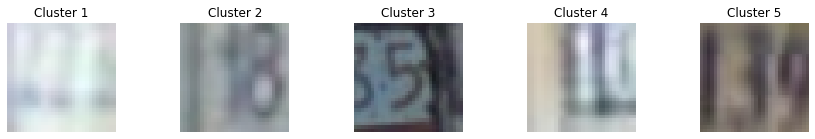

SSE for PCA (Q1a) with k=5: 25042861.79430807


In [ ]:
# Perform K-Means clustering with k=5 on PCA-transformed data (dimension from Q1a)
kmeans_pca_q1a_k5 = KMeans(n_clusters=5, random_state=42)
labels_pca_q1a_k5 = kmeans_pca_q1a_k5.fit_predict(train_data_pca)

# Calculate SSE for PCA (Q1a) with k=5
sse_pca_q1a_k5 = calculate_sse(train_data_pca, labels_pca_q1a_k5, kmeans_pca_q1a_k5.cluster_centers_)

# Display the image closest to each cluster centroid
fig, axes = plt.subplots(1, 5, figsize=(15, 2))

for i in range(5):
    centroid = kmeans_pca_q1a_k5.cluster_centers_[i]
    closest_image_index = np.argmin(np.sum((train_data_pca - centroid) ** 2, axis=1))
    closest_image = train_data_flattened_raw[closest_image_index].reshape(32, 32, 3)

    axes[i].imshow(closest_image)
    axes[i].axis('off')
    axes[i].set_title(f'Cluster {i + 1}')

plt.show()

# Display the SSE
print(f"SSE for PCA (Q1a) with k=5: {sse_pca_q1a_k5}")


In [ ]:
# Analyze the distribution of true labels within each cluster
cluster_labels_distribution = {i: np.bincount(train_labels_subset[labels_pca_q1a_k5 == i].flatten()) for i in range(5)}

for cluster, label_distribution in cluster_labels_distribution.items():
    print(f"Cluster {cluster + 1} - Dominant Class: {np.argmax(label_distribution)}")
    print(f"Class Distribution: {label_distribution}")
    print()


Cluster 1 - Dominant Class: 2
Class Distribution: [  0 456 538 430 475 447 448 476 442 427]

Cluster 2 - Dominant Class: 8
Class Distribution: [  0 649 592 657 649 660 663 641 678 669]

Cluster 3 - Dominant Class: 9
Class Distribution: [  0 713 735 733 697 708 712 704 716 749]

Cluster 4 - Dominant Class: 6
Class Distribution: [  0 218 193 211 200 191 220 160 204 198]

Cluster 5 - Dominant Class: 7
Class Distribution: [  0 464 442 469 479 494 457 519 460 457]



The sum squared error (SSE) for KMeans clustering with k=5 on the PCA-reduced data is given as 25042861.79430807. The SSE is a measure of how close the data points are to their respective cluster centroids. A lower SSE indicates that the data points are closer to the centroids of their assigned clusters.

The class distribution within each cluster shows the count of images from each class that have been assigned to the respective cluster. Based on the provided class distributions for each cluster, we can infer the following:

Clustered Together: None of the clusters represent a single class; instead, each cluster comprises a mixture of all classes. This indicates that the clustering algorithm does not perfectly separate the images by their class labels. However, some clusters may have a higher concentration of certain classes, which could suggest some degree of grouping based on similarities that align with the class definitions.

Classes Getting Clustered Together: To determine which classes are getting clustered together, we would look for clusters where one or two classes dominate the count compared to the others. For example:

Cluster 1 has a relatively higher concentration of classes 5, 8, 9, and 10.
Cluster 2 shows a higher concentration of classes 3, 4, and 9.
Cluster 3 appears to have a relatively uniform distribution but with fewer samples overall, suggesting it may represent outlier data or less common features.
Clusters 4 and 5 do not show a strong skew towards any particular classes.

Inference:

The clusters with higher counts for certain classes suggest that the PCA transformation has brought out some features that are more common within those classes. For instance, images of similar digits might share shape or stroke patterns that cause them to be closer in the PCA-reduced feature space.
The presence of all classes in each cluster, however, indicates that these shared features are not exclusive and that there is a significant overlap in the feature space among the classes.
KMeans, which uses a distance-based metric, may not be capturing the more subtle features that distinguish between the classes, which could be non-linear or not well-separated in the reduced feature space.
The fact that the clusters do not neatly correspond to the classes suggests that for the SVHN dataset, which is inherently more complex due to variations in digit style, color, and environmental background, unsupervised clustering with KMeans may not be sufficient for accurate classification. This is especially true in an unsupervised context without leveraging label information during training. Supervised learning or more advanced unsupervised techniques that can capture complex patterns and non-linear relationships, like autoencoders or neural networks, may yield better results.